[INFO] loading dataset...
Batch size = 16
Train steps = 7
Validation steps = 7
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 122, 128)     147584    
_________________________________________

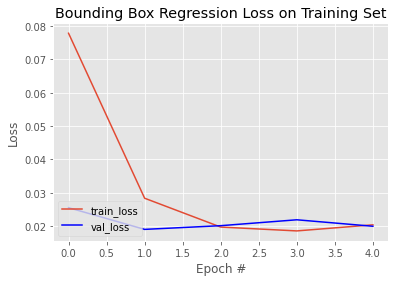

In [7]:
import os
import config
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from preprocess_data_bb import data_generator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, CSVLogger, ReduceLROnPlateau

def prova():
    # callbacks
    save_model_callback = ModelCheckpoint(config.model_detector, monitor='val_loss', save_best_only=True,
                                          mode='auto', verbose=1, period=1)
    early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True,
                                            verbose=1, patience=15)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', mode='auto', factor=0.5, patience=5,
                                           min_lr=0.00001,verbose=1)

    print("[INFO] loading dataset...")
    print("Batch size =", config.batch_size)
    train_data_gen = data_generator(config.train_dir_bb, config.train_csv, config.batch_size)
    val_data_gen = data_generator(config.val_dir_bb, config.val_csv, config.batch_size)
    
    files_train = [f for f in os.listdir(config.train_dir_bb) if os.path.isfile(os.path.join(config.train_dir_bb, f))]
    train_steps = (len(files_train) // config.batch_size) + 1
    
    files_val = [f for f in os.listdir(config.val_dir_bb) if os.path.isfile(os.path.join(config.val_dir_bb, f))]
    val_steps = (len(files_val) // config.batch_size) + 1
        
    print("Train steps =", train_steps)
    print("Validation steps =", val_steps)
    
    # load the VGG16 network
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 244, 3)))

    vgg.trainable = True

    flatten = vgg.output
    flatten = Flatten()(flatten)

    """bboxHead = Dense(128, activation='relu')(flatten)
    bboxHead = Dense(64, activation='relu')(bboxHead)
    bboxHead = Dense(32, activation='relu')(bboxHead)
    bboxHead = Dense(4, activation='sigmoid')(bboxHead)"""
    
    bboxHead = Dense(64, activation='relu')(flatten)
    bboxHead = Dense(32, activation='relu')(bboxHead)
    bboxHead = Dense(16, activation='relu')(bboxHead)
    bboxHead = Dense(4, activation='sigmoid')(bboxHead)

    model = Model(inputs=vgg.input, outputs=bboxHead)

    # initialize the optimizer, compile the model and show the model
    opt = Adam(lr=0.001)
    model.compile(loss='mse', optimizer=opt)
    print(model.summary())
    
    return model

def train(model):
    # callbacks
    save_model_callback = ModelCheckpoint(config.model_detector, monitor='val_loss', save_best_only=True,
                                          mode='auto', verbose=1, period=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', mode='max', restore_best_weights=True,
                                            verbose=1, patience=15)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=0.5, patience=5,
                                           min_lr=0.00001,verbose=1)

    print("[INFO] loading dataset...")
    print("Batch size =", config.batch_size)
    train_data_gen = data_generator(config.train_dir_bb, config.train_csv, config.batch_size)
    val_data_gen = data_generator(config.val_dir_bb, config.val_csv, config.batch_size)
    
    files_train = [f for f in os.listdir(config.train_dir_bb) if os.path.isfile(os.path.join(config.train_dir_bb, f))]
    train_steps = (len(files_train) // config.batch_size) + 1
    
    files_val = [f for f in os.listdir(config.val_dir_bb) if os.path.isfile(os.path.join(config.val_dir_bb, f))]
    val_steps = (len(files_val) // config.batch_size) + 1
        
    print("Train steps =", train_steps)
    print("Validation steps =", val_steps)
    
    """# load the VGG16 network
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 244, 3)))

    vgg.trainable = False

    flatten = vgg.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation='relu')(flatten)
    bboxHead = Dense(64, activation='relu')(bboxHead)
    bboxHead = Dense(32, activation='relu')(bboxHead)
    bboxHead = Dense(4, activation='sigmoid')(bboxHead)

    model = Model(inputs=vgg.input, outputs=bboxHead)

    # initialize the optimizer, compile the model and show the model
    opt = Adam(lr=0.001)
    #model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    model.compile(loss=tfa.losses.GIoULoss(mode='iou'), optimizer=opt)
    print(model.summary())"""

    # train the network for bounding box regression
    print("[INFO] training bounding box regress...")
    history = model.fit(x=train_data_gen, validation_data=val_data_gen, epochs=config.total_epochs, steps_per_epoch=train_steps, 
                        validation_steps=val_steps, verbose=1, callbacks=[save_model_callback, early_stopping_callback,
                        reduce_lr_callback])

    return history


if __name__ == "__main__":
    model = prova()
    H = train(model)

    N = len(H.history['loss'])
    
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
    plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss', color='blue')
    plt.title('Bounding Box Regression Loss on Training Set')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')
    plt.savefig(config.plot_path_loss)
    
    """plt.figure()
    plt.plot(np.arange(0, N), H.history['accuracy'], label='accuracy')
    plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_accuracy', color='blue')
    plt.title('Bounding Box Accuracy on Training Set')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower left')
    plt.savefig(config.plot_path_acc)"""


In [2]:
import os
import cv2
import config
import argparse
import mimetypes
import imutils
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
    
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
    
	# return the intersection over union value
	return iou

In [4]:
imagePath = 'dataset/train/000002_01_01_162.png'

# coordinates real image
realSX = 229
realSY = 256
realEX = 245
realEY = 273

image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# make bounding box predictions on the input image
pred = model.predict(image)[0]
(startX, startY, endX, endY) = pred

# load the input image
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# scale the predicted bounding box coordinates based on the image dimensions
startX = int(startX * h)
startY = int(startY * w)
endX = int(endX * h)
endY = int(endY * w)

boxA = [startX, startY, endX, endY]
boxB = [realSX, realSY, realEX, realEY]

print(boxA)
print(boxB)

# draw the predicted bounding box on the image
im = cv2.rectangle(image, (startX, startY), (endX, endY), (255, 0, 0), 2)
# draw the real bounding box on the image
im = cv2.rectangle(im, (realSX, realSY), (realEX, realEY), (0, 255, 0), 2)

# compute the intersection over union and display it
iou = bb_intersection_over_union(boxA, boxB)


[249, 283, 292, 305]
[229, 256, 245, 273]


dataset/train/000002_01_01_162.png: 0.0000


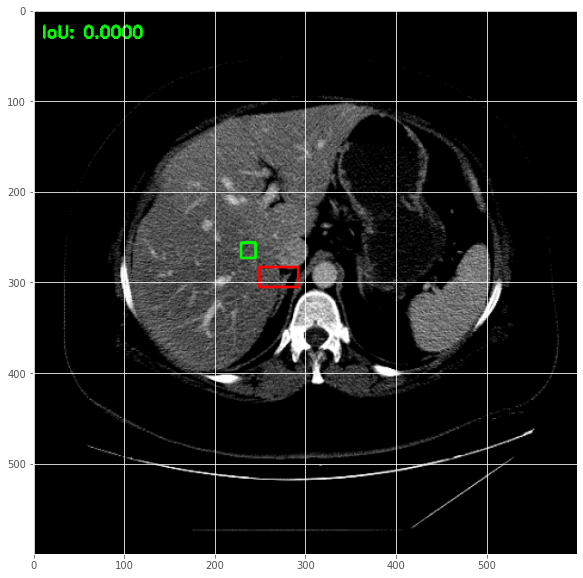

In [5]:
cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
print("{}: {:.4f}".format(imagePath, iou))

# show the outputs image
#cv2.imshow('Output', im)
#cv2.waitKey()
#cv2.destroyWindow('Output') #make sure window closes cleanly

#Show the image with matplotlib
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.show()